In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

def one_hot(labels, num_classes=10):
    onehot = np.zeros((labels.size, num_classes))
    onehot[np.arange(labels.size), labels] = 1
    return onehot

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]


In [2]:
X_train_list, y_train_list = [], []

for image, label in train_dataset:
    image = image.cpu().numpy()
    label = np.array(label)

    image = image.reshape(-1)
    X_train_list.append(image)
    y_train_list.append(label)

X_train = np.array(X_train_list) / 255.0
y_train = np.array(y_train_list)
y_train_oh = one_hot(y_train)


In [3]:
X_val_list, y_val_list = [], []

for image, label in val_dataset:
    image = image.numpy()
    image = image.reshape(-1)

    X_val_list.append(image)
    y_val_list.append(label)

X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
y_val_oh = one_hot(y_val)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train_oh, y_holdout_oh = train_test_split(
    X_train, y_train_oh, test_size=0.1, random_state=42
)


In [5]:
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x): return sigmoid(x) * (1 - sigmoid(x))

def tanh(x): return np.tanh(x)
def tanh_deriv(x): return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [6]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.L = len(layer_sizes) - 1  # number of layers

        # Select activation
        if activation == 'relu':
            self.act = relu
            self.act_deriv = relu_deriv
        elif activation == 'sigmoid':
            self.act = sigmoid
            self.act_deriv = sigmoid_deriv
        else:
            self.act = tanh
            self.act_deriv = tanh_deriv

        # Initialize parameters
        self.W = []
        self.b = []
        for i in range(self.L):
            self.W.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i]))
            self.b.append(np.zeros((1, layer_sizes[i+1])))

In [7]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.L = len(layer_sizes) - 1

        if activation == 'relu':
            self.act, self.act_deriv = relu, relu_deriv
        elif activation == 'sigmoid':
            self.act, self.act_deriv = sigmoid, sigmoid_deriv
        else:
            self.act, self.act_deriv = tanh, tanh_deriv

        self.W, self.b = [], []
        for i in range(self.L):
            self.W.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i]))
            self.b.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):  # ✅ INSIDE CLASS
        self.A = [X]
        self.Z = []

        for i in range(self.L - 1):
            Z = self.A[-1] @ self.W[i] + self.b[i]
            A = self.act(Z)
            self.Z.append(Z)
            self.A.append(A)

        Z = self.A[-1] @ self.W[-1] + self.b[-1]
        A = softmax(Z)
        self.Z.append(Z)
        self.A.append(A)
        return A

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, y_true):
        m = y_true.shape[0]
        self.dW = [None]*self.L
        self.db = [None]*self.L

        dA = self.A[-1] - y_true

        for i in reversed(range(self.L)):
            dZ = dA if i == self.L-1 else dA * self.act_deriv(self.Z[i])
            self.dW[i] = self.A[i].T @ dZ / m
            self.db[i] = np.sum(dZ, axis=0, keepdims=True) / m

            if i != 0:
                dA = dZ @ self.W[i].T

    def update_parameters(self):
        for i in range(self.L):
            self.W[i] -= self.lr * self.dW[i]
            self.b[i] -= self.lr * self.db[i]

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y_labels):
        preds = self.predict(X)
        return np.mean(preds == y_labels)

In [8]:
def train(model, X_train, y_train_oh, y_train_labels, X_val, y_val_oh, y_val_labels, epochs=10, batch_size=64):
    n = X_train.shape[0]
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        perm = np.random.permutation(n)
        X_train, y_train_oh, y_train_labels = X_train[perm], y_train_oh[perm], y_train_labels[perm]

        for i in range(0, n, batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train_oh[i:i+batch_size]

            model.forward(X_batch)
            model.backward(y_batch)
            model.update_parameters()

        train_pred = model.forward(X_train)
        val_pred = model.forward(X_val)

        train_loss = model.compute_loss(train_pred, y_train_oh)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        train_acc = model.evaluate(X_train, y_train_labels)
        val_acc = model.evaluate(X_val, y_val_labels)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [9]:
layer_sizes = [784, 128, 10]
model = NeuralNetwork(layer_sizes, activation='relu', lr=0.01)

train_losses, val_losses, train_accs, val_accs = train(
    model, X_train, y_train_oh, y_train, X_val, y_val_oh, y_val, epochs=10
)

Epoch 1: Train Loss=2.2998, Train Acc=0.1132, Val Acc=0.0829
Epoch 2: Train Loss=2.2995, Train Acc=0.1132, Val Acc=0.0907
Epoch 3: Train Loss=2.2993, Train Acc=0.1132, Val Acc=0.0984
Epoch 4: Train Loss=2.2991, Train Acc=0.1132, Val Acc=0.1072
Epoch 5: Train Loss=2.2989, Train Acc=0.1132, Val Acc=0.1178
Epoch 6: Train Loss=2.2987, Train Acc=0.1132, Val Acc=0.1273
Epoch 7: Train Loss=2.2985, Train Acc=0.1132, Val Acc=0.1366
Epoch 8: Train Loss=2.2983, Train Acc=0.1132, Val Acc=0.1476
Epoch 9: Train Loss=2.2980, Train Acc=0.1132, Val Acc=0.1580
Epoch 10: Train Loss=2.2978, Train Acc=0.1132, Val Acc=0.1705


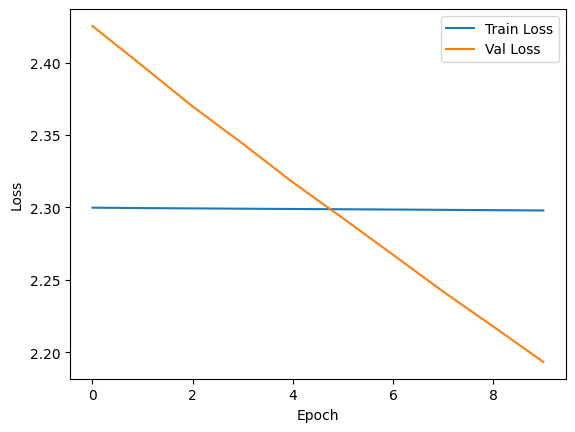

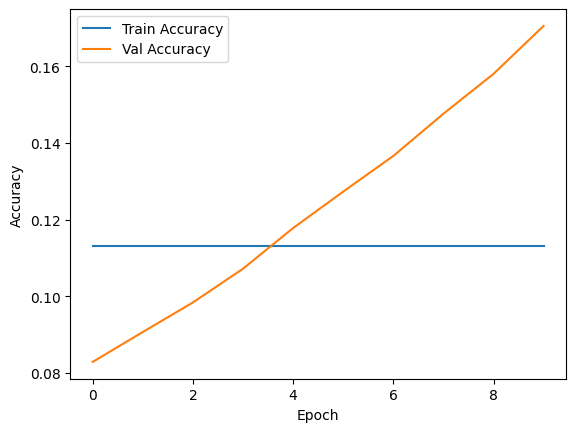

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.png")
plt.show()

plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve.png")
plt.show()

In [ ]:
configs = [
    ([784,128,10],'relu'),
    ([784,256,128,10],'relu'),
    ([784,128,10],'sigmoid'),
    ([784,128,64,10],'tanh')
]

for layers, act in configs:
    print(f"\nTraining config: {layers}, activation={act}")
    model = NeuralNetwork(layers, activation=act, lr=0.01)
    train(model, X_train, y_train_oh, y_train, X_val, y_val_oh, y_val, epochs=5)


Training config: [784, 128, 10], activation=relu
Epoch 1: Train Loss=2.2999, Train Acc=0.1132, Val Acc=0.1205
Epoch 2: Train Loss=2.2996, Train Acc=0.1132, Val Acc=0.1306
Epoch 3: Train Loss=2.2994, Train Acc=0.1132, Val Acc=0.1429
Epoch 4: Train Loss=2.2992, Train Acc=0.1132, Val Acc=0.1541
Epoch 5: Train Loss=2.2990, Train Acc=0.1132, Val Acc=0.1677

Training config: [784, 256, 128, 10], activation=relu
